# Обнаружение статистически значимых отличий в уровнях экспрессии генов больных раком

Это задание поможет вам лучше разобраться в методах множественной проверки гипотез и позволит применить ваши знания на данных из реального биологического исследования.

### В этом задании вы:

* вспомните, что такое t-критерий Стьюдента и для чего он применяется
* сможете применить технику множественной проверки гипотез и увидеть собственными глазами, как она работает на реальных данных
* почувствуете разницу в результатах применения различных методов поправки на множественную проверку

### Основные библиотеки и используемые методы:

Библиотека scipy и основные статистические функции:http://docs.scipy.org/doc/scipy/reference/stats.html#statistical-functions

Библиотека statmodels для методов коррекции при множественном сравнении:

http://statsmodels.sourceforge.net/devel/stats.html

Статья, в которой рассматриваются примеры использования statsmodels для множественной проверки гипотез:

http://jpktd.blogspot.ru/2013/04/multiple-testing-p-value-corrections-in.html

### Описание используемых данных

Данные для этой задачи взяты из исследования, проведенного в Stanford School of Medicine. В исследовании была предпринята попытка выявить набор  генов, которые позволили  бы более точно диагностировать возникновение рака груди на самых ранних стадиях.

В эксперименте принимали участие 24 человек, у которых не было рака груди (normal), 25 человек, у которых это заболевание было диагностировано на ранней стадии (early neoplasia), и 23 человека с сильно выраженными симптомами (cancer).

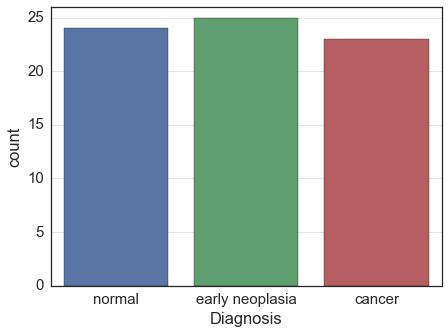

In [1]:
from PIL import Image
Image.open('image1.png')

Ученые провели секвенирование биологического материала испытуемых, чтобы понять, какие из этих генов наиболее активны в клетках больных людей. 

Секвенирование — это определение степени активности генов в анализируемом образце с помощью подсчёта количества соответствующей каждому гену РНК.

В данных для этого задания вы найдете именно эту количественную меру активности каждого из 15748 генов у каждого из 72 человек, принимавших участие в эксперименте.

Вам нужно будет определить те гены, активность которых у людей в разных стадиях заболевания отличается статистически значимо.

Кроме того, вам нужно будет оценить не только статистическую, но и практическую значимость этих результатов, которая часто используется в подобных исследованиях.

Диагноз человека содержится в столбце под названием "Diagnosis".

### Практическая значимость изменения

Цель исследований — найти гены, средняя экспрессия которых отличается не только статистически значимо, но и достаточно сильно. В экспрессионных исследованиях для этого часто используется метрика, которая называется fold change (кратность изменения). Определяется она следующим образом:

$F_{c}\left(C, T\right)=\begin{cases}\frac{T}{C}, & T>C\\-\frac{C}{T} & T<C\end{cases}$

где C,T — средние значения экспрессии гена в control и treatment группах соответственно. По сути, fold change показывает, во сколько раз отличаются средние двух выборок.

### Инструкции к решению задачи

Задание состоит из трёх частей. Если не сказано обратное, то уровень значимости нужно принять равным 0.05.

## Часть 1: применение t-критерия Стьюдента

В первой части вам нужно будет применить критерий Стьюдента для проверки гипотезы о равенстве средних в двух независимых выборках. Применить критерий для каждого гена нужно будет дважды:

1. для групп <b>normal (control)</b> и <b>early neoplasia (treatment)</b>
2. для групп early <b>neoplasia (control)</b> и <b>cancer (treatment)</b>

В качестве ответа в этой части задания необходимо указать количество статистически значимых отличий, которые вы нашли с помощью t-критерия Стьюдента, то есть число генов, у которых p-value этого теста оказался меньше, чем уровень значимости.

In [2]:
import numpy as np
import pandas as pd
import scipy
from statsmodels.sandbox.stats.multicomp import multipletests

In [3]:
df_all = pd.read_csv('gene_high_throughput_sequencing.csv')

In [4]:
df_all.head(10)

,Patient_id,Diagnosis,LOC643837,LOC100130417,SAMD11,NOC2L,KLHL17,PLEKHN1,C1orf170,HES4,...,CLIC2,RPS4Y1,ZFY,PRKY,USP9Y,DDX3Y,CD24,CYorf15B,KDM5D,EIF1AY
0,STT5425_Breast_001_normal,normal,1.257614,2.408148,13.368622,9.494779,20.880435,12.722017,9.494779,54.349694,...,4.761250,1.257614,1.257614,1.257614,1.257614,1.257614,23.268694,1.257614,1.257614,1.257614
1,STT5427_Breast_023_normal,normal,4.567931,16.602734,42.477752,25.562376,23.221137,11.622386,14.330573,72.445474,...,6.871902,1.815112,1.815112,1.815112,1.815112,1.815112,10.427023,1.815112,1.815112,1.815112
2,STT5430_Breast_002_normal,normal,2.077597,3.978294,12.863214,13.728915,14.543176,14.141907,6.232790,57.011005,...,7.096343,2.077597,2.077597,2.077597,2.077597,2.077597,22.344226,2.077597,2.077597,2.077597
3,STT5439_Breast_003_normal,normal,2.066576,8.520713,14.466035,7.823932,8.520713,2.066576,10.870009,53.292034,...,5.200770,2.066576,2.066576,2.066576,2.066576,2.066576,49.295538,2.066576,2.066576,2.066576
4,STT5441_Breast_004_normal,normal,2.613616,3.434965,12.682222,10.543189,26.688686,12.484822,1.364917,67.140393,...,11.227770,1.364917,1.364917,1.364917,1.364917,1.364917,23.627911,1.364917,1.364917,1.364917
5,STT5446_Breast_005_normal,normal,3.942275,4.488477,8.944837,12.581469,23.543887,8.683617,5.418139,50.525641,...,8.683617,1.314092,1.314092,1.314092,1.314092,1.314092,18.001936,1.314092,1.314092,1.314092
6,STT5451_Breast_006_normal,normal,1.084113,3.252340,8.917889,11.249037,19.179923,6.712171,12.439778,52.498406,...,9.091914,1.084113,1.084113,1.084113,1.084113,1.084113,11.659470,1.084113,1.084113,1.084113
7,STT5466_Breast_007_normal,normal,3.153900,1.647070,4.941211,11.529492,13.813151,8.235352,1.647070,44.226216,...,10.546396,1.647070,1.647070,1.647070,1.647070,1.647070,21.071346,1.647070,1.647070,1.647070
8,STT5472_Breast_008_normal,normal,2.551800,3.838876,16.255376,12.972108,20.169502,7.097877,5.333458,52.003891,...,9.274845,1.013982,1.013982,1.013982,1.013982,1.013982,11.030215,1.013982,1.013982,1.013982
9,STT5475_Breast_009_normal,normal,3.693128,1.231043,11.079385,12.453221,21.024058,6.780055,6.155214,49.174985,...,8.848678,1.231043,1.231043,1.231043,1.231043,1.231043,24.896300,1.231043,1.231043,1.231043


In [5]:
df_all.shape

(72, 15750)

In [6]:
df_normal = df_all[df_all['Diagnosis'] == 'normal']
df_early_neoplasia = df_all[df_all['Diagnosis'] == 'early neoplasia']
df_cancer = df_all[df_all['Diagnosis'] == 'cancer']

In [7]:
df_normal.head(10)

,Patient_id,Diagnosis,LOC643837,LOC100130417,SAMD11,NOC2L,KLHL17,PLEKHN1,C1orf170,HES4,...,CLIC2,RPS4Y1,ZFY,PRKY,USP9Y,DDX3Y,CD24,CYorf15B,KDM5D,EIF1AY
0,STT5425_Breast_001_normal,normal,1.257614,2.408148,13.368622,9.494779,20.880435,12.722017,9.494779,54.349694,...,4.761250,1.257614,1.257614,1.257614,1.257614,1.257614,23.268694,1.257614,1.257614,1.257614
1,STT5427_Breast_023_normal,normal,4.567931,16.602734,42.477752,25.562376,23.221137,11.622386,14.330573,72.445474,...,6.871902,1.815112,1.815112,1.815112,1.815112,1.815112,10.427023,1.815112,1.815112,1.815112
2,STT5430_Breast_002_normal,normal,2.077597,3.978294,12.863214,13.728915,14.543176,14.141907,6.232790,57.011005,...,7.096343,2.077597,2.077597,2.077597,2.077597,2.077597,22.344226,2.077597,2.077597,2.077597
3,STT5439_Breast_003_normal,normal,2.066576,8.520713,14.466035,7.823932,8.520713,2.066576,10.870009,53.292034,...,5.200770,2.066576,2.066576,2.066576,2.066576,2.066576,49.295538,2.066576,2.066576,2.066576
4,STT5441_Breast_004_normal,normal,2.613616,3.434965,12.682222,10.543189,26.688686,12.484822,1.364917,67.140393,...,11.227770,1.364917,1.364917,1.364917,1.364917,1.364917,23.627911,1.364917,1.364917,1.364917
5,STT5446_Breast_005_normal,normal,3.942275,4.488477,8.944837,12.581469,23.543887,8.683617,5.418139,50.525641,...,8.683617,1.314092,1.314092,1.314092,1.314092,1.314092,18.001936,1.314092,1.314092,1.314092
6,STT5451_Breast_006_normal,normal,1.084113,3.252340,8.917889,11.249037,19.179923,6.712171,12.439778,52.498406,...,9.091914,1.084113,1.084113,1.084113,1.084113,1.084113,11.659470,1.084113,1.084113,1.084113
7,STT5466_Breast_007_normal,normal,3.153900,1.647070,4.941211,11.529492,13.813151,8.235352,1.647070,44.226216,...,10.546396,1.647070,1.647070,1.647070,1.647070,1.647070,21.071346,1.647070,1.647070,1.647070
8,STT5472_Breast_008_normal,normal,2.551800,3.838876,16.255376,12.972108,20.169502,7.097877,5.333458,52.003891,...,9.274845,1.013982,1.013982,1.013982,1.013982,1.013982,11.030215,1.013982,1.013982,1.013982
9,STT5475_Breast_009_normal,normal,3.693128,1.231043,11.079385,12.453221,21.024058,6.780055,6.155214,49.174985,...,8.848678,1.231043,1.231043,1.231043,1.231043,1.231043,24.896300,1.231043,1.231043,1.231043


In [8]:
df_normal.shape

(24, 15750)

In [9]:
df_early_neoplasia.head(10)

,Patient_id,Diagnosis,LOC643837,LOC100130417,SAMD11,NOC2L,KLHL17,PLEKHN1,C1orf170,HES4,...,CLIC2,RPS4Y1,ZFY,PRKY,USP9Y,DDX3Y,CD24,CYorf15B,KDM5D,EIF1AY
24,STT5424_Breast_001_EN,early neoplasia,2.516305,11.430887,18.506550,13.969049,20.957007,10.374992,8.414330,68.513944,...,4.488498,1.314098,1.314098,1.314098,3.307073,1.314098,25.059902,1.314098,1.314098,1.314098
25,STT5431_Breast_002_EN,early neoplasia,1.937270,9.686352,23.541357,15.295034,18.815807,11.128772,9.155183,67.951908,...,3.709591,1.937270,1.937270,1.937270,1.937270,1.937270,26.349727,1.937270,1.937270,1.937270
26,STT5442_Breast_004_EN,early neoplasia,1.405858,15.119783,17.985461,17.237294,21.824785,4.801919,5.796501,67.064975,...,7.029290,1.405858,1.405858,1.405858,1.405858,1.405858,29.254009,1.405858,1.405858,1.405858
27,STT5445_Breast_005_EN,early neoplasia,2.131757,8.789458,12.731187,6.395270,19.185811,14.922297,4.082003,52.028259,...,9.453726,2.131757,2.131757,2.131757,2.131757,2.131757,23.189490,2.131757,2.131757,2.131757
28,STT5511_Breast_011_EN,early neoplasia,2.421766,7.830416,18.283935,15.229320,29.234970,15.779540,8.098199,50.224123,...,5.976863,1.264726,1.264726,1.264726,1.264726,1.264726,19.849890,1.264726,1.264726,1.264726
29,STT5426_Breast_023_EN,early neoplasia,4.668232,14.949208,27.070696,19.599600,34.110743,13.633645,12.859463,73.663460,...,2.168022,1.132213,1.132213,1.132213,2.849339,1.132213,9.495298,1.132213,1.132213,1.132213
30,STT5440_Breast_003_EN,early neoplasia,3.386331,12.379176,28.350470,14.547256,22.989898,14.257730,6.695258,79.737458,...,6.040419,1.768454,1.768454,1.768454,1.768454,1.768454,17.889667,1.768454,1.768454,1.768454
31,STT5449_Breast_006_EN,early neoplasia,1.247440,4.260819,11.410269,8.966540,16.470617,5.143327,4.722732,43.897364,...,10.461652,1.247440,1.247440,1.247440,1.247440,1.247440,22.349725,1.247440,1.247440,1.247440
32,STT5465_Breast_007_EN,early neoplasia,1.591747,8.372450,13.349184,9.855131,20.197009,11.441405,8.766661,48.376201,...,9.506166,1.591747,1.591747,1.591747,1.591747,1.591747,18.264679,1.591747,1.591747,1.591747
33,STT5476_Breast_009_EN,early neoplasia,0.979074,3.706715,17.686680,12.727965,26.435003,14.598825,11.120145,59.830433,...,7.562780,0.979074,0.979074,0.979074,0.979074,0.979074,22.461877,0.979074,0.979074,0.979074


In [10]:
df_early_neoplasia.shape

(25, 15750)

In [11]:
df_cancer.head(10)

,Patient_id,Diagnosis,LOC643837,LOC100130417,SAMD11,NOC2L,KLHL17,PLEKHN1,C1orf170,HES4,...,CLIC2,RPS4Y1,ZFY,PRKY,USP9Y,DDX3Y,CD24,CYorf15B,KDM5D,EIF1AY
49,STT5437_Breast_003_DCIS,cancer,1.618129,4.854387,7.646980,11.631036,19.839961,19.484855,15.492407,78.090449,...,7.175936,1.618129,1.618129,1.618129,1.618129,1.618129,22.008936,1.618129,1.618129,1.618129
50,STT5450_Breast_006_DCIS,cancer,1.609022,10.632542,28.344988,18.462903,23.702379,13.494061,6.091660,58.775216,...,6.091660,1.609022,1.609022,1.609022,1.609022,1.609022,24.840164,1.609022,1.609022,1.609022
51,STT5462_Breast_007_DCIS,cancer,1.549953,3.900629,12.496120,10.242207,22.972095,16.860563,7.324792,76.410218,...,6.873594,1.549953,1.549953,1.549953,1.549953,1.549953,18.834745,1.549953,1.549953,1.549953
52,STT5463_Breast_007_IDC,cancer,1.606786,4.043656,8.849487,15.158388,26.287855,27.441093,8.033929,132.144503,...,1.606786,1.606786,1.606786,1.606786,1.606786,1.606786,21.215253,1.606786,1.606786,1.606786
53,STT5474_Breast_008_IDC,cancer,2.697819,8.225604,21.299676,14.114099,22.289155,14.341455,5.567752,59.058349,...,7.099892,0.899273,0.899273,0.899273,0.899273,0.899273,20.368088,0.899273,0.899273,0.899273
54,STT5477_Breast_009_IDC,cancer,1.126738,4.996760,13.442388,11.691325,21.169493,8.703401,6.729059,58.340683,...,7.214646,1.126738,1.126738,1.126738,1.126738,1.126738,8.098943,1.126738,1.126738,1.126738
55,STT5504_Breast_010_DCIS,cancer,3.163299,11.208777,25.033996,14.749504,28.573643,18.891720,12.813277,45.045398,...,5.546224,1.054433,1.054433,1.054433,1.054433,1.054433,28.521715,1.054433,1.054433,1.054433
56,STT5568_Breast_012_DCIS,cancer,1.428276,6.749770,14.635476,14.066889,22.172809,14.258937,13.872182,45.667628,...,4.284829,1.428276,1.428276,1.428276,1.428276,1.428276,11.515131,1.428276,1.428276,1.428276
57,STT5572_Breast_013_IDC,cancer,2.604658,7.045005,23.623998,13.348245,25.032975,11.995723,6.408005,49.690114,...,7.813974,1.034986,1.034986,1.034986,1.034986,1.034986,13.132502,1.034986,1.034986,1.034986
58,STT5575_Breast_014_IDC,cancer,3.331313,7.558592,25.346209,17.142989,30.953137,13.123224,10.317712,70.472701,...,4.578452,1.110438,1.110438,1.110438,1.110438,1.110438,11.804114,1.110438,1.110438,1.110438


In [12]:
df_cancer.shape

(23, 15750)

In [13]:
gene_names = np.array(df_all.columns)[2:]

In [14]:
sign_level = 0.05
p_val = []
fold_change =[]
for gene_name in gene_names:
    res = scipy.stats.ttest_ind(df_normal[gene_name],
                                df_early_neoplasia[gene_name],
                                equal_var = False)
    p_val.append(res[1])
    C = df_normal[gene_name].mean()
    T = df_early_neoplasia[gene_name].mean()
    if T > C:
        fold_change.append(T / C)
    else:
        fold_change.append(C / T)
df_comp_normal_and_early_neoplasia = pd.DataFrame({'gene_name': gene_names,
                                                   'fold_change': fold_change,
                                                   'p_value': p_val})
df_comp_normal_and_early_neoplasia = df_comp_normal_and_early_neoplasia[['gene_name',
                                                                         'fold_change',
                                                                         'p_value']]
df_comp_normal_and_early_neoplasia.head(10)

,gene_name,fold_change,p_value
0,LOC643837,1.067858,0.690766
1,LOC100130417,1.996517,0.000032
2,SAMD11,1.222418,0.060273
3,NOC2L,1.020070,0.826429
4,KLHL17,1.125471,0.049876
5,PLEKHN1,1.151327,0.144267
6,C1orf170,1.111462,0.329108
7,HES4,1.113459,0.023712
8,ISG15,1.066094,0.240148
9,AGRN,1.204175,0.037933


In [15]:
dif_act_gene_num = (df_comp_normal_and_early_neoplasia['p_value'] < sign_level).value_counts()
print dif_act_gene_num

False    14173
True      1575
Name: p_value, dtype: int64


## Часть 2: поправка методом Холма

Для этой части задания вам понадобится модуль multipletests из statsmodels.

from statsmodels.sandbox.stats.multicomp import multipletests

В этой части задания нужно будет применить поправку Холма для получившихся двух наборов достигаемых уровней значимости из предыдущей части. Обратите внимание, что поскольку вы будете делать поправку для каждого из двух наборов p-value отдельно, то проблема, связанная с множественной проверкой останется.

Для того, чтобы ее устранить, достаточно воспользоваться поправкой Бонферрони, то есть использовать уровень значимости 0.05 / 2 вместо 0.05 для дальнейшего уточнения значений p-value c помощью метода Холма.

В качестве ответа к этому заданию требуется ввести количество значимых отличий в каждой группе после того, как произведена коррекция Холма-Бонферрони. Причем это число нужно ввести с учетом практической значимости: посчитайте для каждого значимого изменения fold change и выпишите в ответ число таких значимых изменений, абсолютное значение fold change которых больше, чем 
1.5
1.5.

<b>Обратите внимание, что</b>

* применять поправку на множественную проверку  нужно  <b>ко всем  значениям достигаемых уровней значимости, а не только для тех, которые меньше значения уровня доверия.</b>
* при использовании поправки на уровне значимости 0.025 <b>меняются значения достигаемого уровня значимости, но не меняется значение уровня доверия</b> (то есть для отбора значимых изменений скорректированные значения уровня значимости нужно сравнивать с порогом 0.025, а не 0.05)!

In [16]:
from statsmodels.sandbox.stats.multicomp import multipletests

In [17]:
sign_level = 0.05
p_val = []
fold_change =[]
for gene_name in gene_names:
    res = scipy.stats.ttest_ind(df_early_neoplasia[gene_name],
                                df_cancer[gene_name],
                                equal_var = False)
    p_val.append(res[1])
    C = df_early_neoplasia[gene_name].mean()
    T = df_cancer[gene_name].mean()
    if T > C:
        fold_change.append(T / C)
    else:
        fold_change.append(C / T)
df_comp_early_neoplasia_and_cancer = pd.DataFrame({'gene_name': gene_names,
                                                   'fold_change': fold_change,
                                                   'p_value': p_val})
df_comp_early_neoplasia_and_cancer = df_comp_early_neoplasia_and_cancer[['gene_name',
                                                                         'fold_change',
                                                                         'p_value']]
df_comp_early_neoplasia_and_cancer.head(10)

,gene_name,fold_change,p_value
0,LOC643837,1.148593,0.413735
1,LOC100130417,1.064871,0.653429
2,SAMD11,1.278517,0.079556
3,NOC2L,1.092635,0.287581
4,KLHL17,1.036574,0.463292
5,PLEKHN1,1.285160,0.007681
6,C1orf170,1.074193,0.481306
7,HES4,1.038536,0.578830
8,ISG15,2.458867,0.000740
9,AGRN,1.032005,0.712687


In [18]:
dif_act_gene_num = (df_comp_early_neoplasia_and_cancer['p_value'] < sign_level).value_counts()
print dif_act_gene_num

False    12258
True      3490
Name: p_value, dtype: int64


In [19]:
sign_level = 0.025
reject, p_value_corrected, a1, a2 = multipletests(df_comp_normal_and_early_neoplasia.p_value, alpha = sign_level, method = 'holm')

In [20]:
df_comp_normal_and_early_neoplasia['p_value_corrected'] = p_value_corrected
df_comp_normal_and_early_neoplasia['reject'] = reject

In [21]:
df_comp_normal_and_early_neoplasia.head(10)

,gene_name,fold_change,p_value,p_value_corrected,reject
0,LOC643837,1.067858,0.690766,1.000000,False
1,LOC100130417,1.996517,0.000032,0.500174,False
2,SAMD11,1.222418,0.060273,1.000000,False
3,NOC2L,1.020070,0.826429,1.000000,False
4,KLHL17,1.125471,0.049876,1.000000,False
5,PLEKHN1,1.151327,0.144267,1.000000,False
6,C1orf170,1.111462,0.329108,1.000000,False
7,HES4,1.113459,0.023712,1.000000,False
8,ISG15,1.066094,0.240148,1.000000,False
9,AGRN,1.204175,0.037933,1.000000,False


In [22]:
((df_comp_normal_and_early_neoplasia['reject']) & (abs(df_comp_normal_and_early_neoplasia['fold_change']) > 1.5)).value_counts()

False    15746
True         2
dtype: int64

In [23]:
sign_level = 0.025
reject, p_value_corrected, a1, a2 = multipletests(df_comp_early_neoplasia_and_cancer.p_value, alpha = sign_level, method = 'holm')

In [24]:
df_comp_early_neoplasia_and_cancer['p_value_corrected'] = p_value_corrected
df_comp_early_neoplasia_and_cancer['reject'] = reject

In [25]:
df_comp_early_neoplasia_and_cancer.head(10)

,gene_name,fold_change,p_value,p_value_corrected,reject
0,LOC643837,1.148593,0.413735,1.0,False
1,LOC100130417,1.064871,0.653429,1.0,False
2,SAMD11,1.278517,0.079556,1.0,False
3,NOC2L,1.092635,0.287581,1.0,False
4,KLHL17,1.036574,0.463292,1.0,False
5,PLEKHN1,1.285160,0.007681,1.0,False
6,C1orf170,1.074193,0.481306,1.0,False
7,HES4,1.038536,0.578830,1.0,False
8,ISG15,2.458867,0.000740,1.0,False
9,AGRN,1.032005,0.712687,1.0,False


In [26]:
((df_comp_early_neoplasia_and_cancer['reject']) & (abs(df_comp_early_neoplasia_and_cancer['fold_change']) > 1.5)).value_counts()

False    15671
True        77
dtype: int64

## Часть 3: поправка методом Бенджамини-Хохберга

Данная часть задания аналогична второй части за исключением того, что нужно будет использовать метод Бенджамини-Хохберга.

 Обратите внимание, что методы коррекции, которые контролируют FDR, допускает больше ошибок первого рода и имеют большую мощность, чем методы, контролирующие FWER. Большая мощность означает, что эти методы будут совершать меньше ошибок второго рода (то есть будут лучше улавливать отклонения от $H_{0}$, когда они есть, и будут чаще отклонять $H_{0}$, когда отличий нет).

В качестве ответа к этому заданию требуется  ввести количество значимых отличий в каждой группе после того, как произведена коррекция Бенджамини-Хохберга, причем так же, как и во второй части, считать только такие отличия, у которых abs(fold change) > 1.5. 

In [27]:
sign_level = 0.025
reject, p_value_corrected, a1, a2 = multipletests(df_comp_normal_and_early_neoplasia.p_value, alpha = sign_level, method = 'fdr_bh')

In [28]:
df_comp_normal_and_early_neoplasia['p_value_corrected'] = p_value_corrected
df_comp_normal_and_early_neoplasia['reject'] = reject

In [29]:
df_comp_normal_and_early_neoplasia.head(10)

,gene_name,fold_change,p_value,p_value_corrected,reject
0,LOC643837,1.067858,0.690766,0.966511,False
1,LOC100130417,1.996517,0.000032,0.035698,False
2,SAMD11,1.222418,0.060273,0.536103,False
3,NOC2L,1.020070,0.826429,0.980777,False
4,KLHL17,1.125471,0.049876,0.499016,False
5,PLEKHN1,1.151327,0.144267,0.702934,False
6,C1orf170,1.111462,0.329108,0.858283,False
7,HES4,1.113459,0.023712,0.386566,False
8,ISG15,1.066094,0.240148,0.794398,False
9,AGRN,1.204175,0.037933,0.453033,False


In [30]:
((df_comp_normal_and_early_neoplasia['reject']) & (abs(df_comp_normal_and_early_neoplasia['fold_change']) > 1.5)).value_counts()

False    15744
True         4
dtype: int64

In [31]:
sign_level = 0.025
reject, p_value_corrected, a1, a2 = multipletests(df_comp_early_neoplasia_and_cancer.p_value, alpha = sign_level, method = 'fdr_bh')

In [32]:
df_comp_early_neoplasia_and_cancer['p_value_corrected'] = p_value_corrected
df_comp_early_neoplasia_and_cancer['reject'] = reject

In [33]:
df_comp_early_neoplasia_and_cancer.head(10)

,gene_name,fold_change,p_value,p_value_corrected,reject
0,LOC643837,1.148593,0.413735,0.675195,False
1,LOC100130417,1.064871,0.653429,0.836406,False
2,SAMD11,1.278517,0.079556,0.288873,False
3,NOC2L,1.092635,0.287581,0.563007,False
4,KLHL17,1.036574,0.463292,0.712214,False
5,PLEKHN1,1.285160,0.007681,0.073759,False
6,C1orf170,1.074193,0.481306,0.724319,False
7,HES4,1.038536,0.578830,0.789177,False
8,ISG15,2.458867,0.000740,0.017556,True
9,AGRN,1.032005,0.712687,0.867274,False


In [34]:
((df_comp_early_neoplasia_and_cancer['reject']) & (abs(df_comp_early_neoplasia_and_cancer['fold_change']) > 1.5)).value_counts()

False    15224
True       524
dtype: int64